<h1><b><center>NEURAL NETWORKS MINI-PROJECT - CIFAR-10 CLASSIFICATION</center></b></h1>

**Preparing CIFAR-10 Dataset** - We prepare the CIFAR-10 dataset for training and testing by applying data augmentation and normalization techniques, then create DataLoader objects to efficiently load the data in batches. 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the data augmentation and normalization transformations for the training dataset
transform_train = transforms.Compose([
    # Resize the images to 32x32 pixels
    transforms.Resize((32, 32)),
    # Apply random affine transformations to the images (rotation, translation, and scaling)
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # Apply random color jitter to the images (brightness, contrast, saturation, and hue adjustments)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Randomly flip the images horizontally
    transforms.RandomHorizontalFlip(),
    # Convert the images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize the tensors by subtracting the mean and dividing by the standard deviation
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Define the normalization transformations for the test dataset
transform_test = transforms.Compose([
    # Convert the images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize the tensors by subtracting the mean and dividing by the standard deviation
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**Visualizing a Sample** - We visualize a random subset of 10 images from the CIFAR-10 training dataset. The images are first de-normalized and transposed to a format suitable for display. A grid of subplots is then created to display the images, with each subplot showing the image and its corresponding label. 

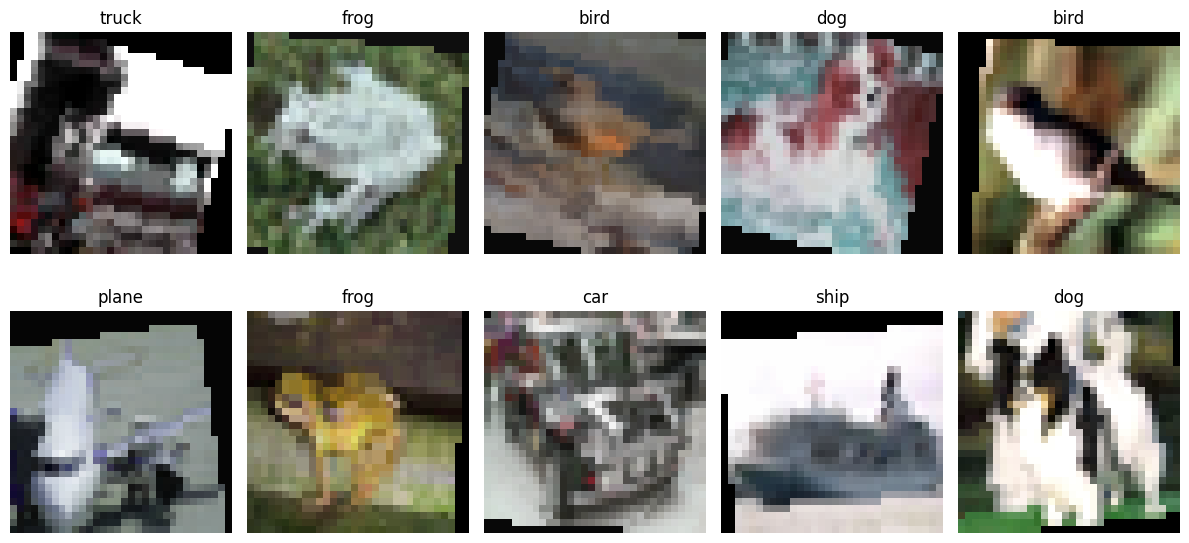

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the classes for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get a batch of images and labels from the trainloader
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# Randomly select 10 images from the batch
indices = np.random.choice(range(len(images)), size=10, replace=False)
images = images[indices]
labels = labels[indices]

# De-normalize the images to reverse the normalization applied during data preprocessing
images = (images * 0.5) + 0.5

# Transpose the images to be in the format (height, width, channels) for display
images = np.transpose(images, (0, 2, 3, 1))

# Create a grid of subplots with 2 rows and 5 columns to display 10 images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

# Loop through each subplot and plot the corresponding image and label
for i, ax in enumerate(axes.flat):
    # Plot the image in the current subplot
    ax.imshow(images[i])
    
    # Get the label of the image
    label = classes[labels[i]]
    
    # Set the title of the subplot as the image label
    ax.set_title(label, fontsize=12)
    # Remove axis markings
    ax.axis('off')

# Show the plot with the grid of images
plt.tight_layout()
plt.show()


**Creating the Model** - We now define a neural network model according to specifications given in 'Mini Project Problem.pdf' for the CIFAR-10 dataset. The model consists of a series of Block instances that perform adaptive convolutions based on channel-wise weights. Each Block contains multiple convolutional layers, and the weights are calculated using a fully connected layer with input from an adaptive average pooling layer. The model also has residual connections to enhance the learning of the network. The CIFAR10Model consists of a backbone made up of these blocks, as well as a classifier that maps the output of the backbone to the final class scores.

**How the Model created adheres to the given specifications:**<br>

**The Model:**<br>
The model architecture is based on Convolutional Neural Networks, suitable for processing images.
The model consists of a backbone with 11 blocks (B1, B2, ..., B11) and a Classifier C. <br>

***The Backbone:***<br>
The backbone consists of 11 blocks. Each block is an instance of the Block class in the code. Our implementation for each block includes:<br>
• A Linear/MLP layer predicting a vector a = [a1, a2, ..., ak] with K elements from the input tensor X. In our code, this is achieved by applying the fully connected layer self.fc on the output of the adaptive average pooling self.avg_pool(x).view(b, c) (where x is the input tensor).<br>
• K Conv layers (defined as self.convs in our code) are combined using vector a to produce a single output:<br>
<center>O = a1 * Conv1(x) + ... + ak * Conv_k(x)</center>

This is accomplished in the forward method of the Block class with the following loop:<br>
<center>for i, conv in enumerate(self.convs): out += a[:, i:i + 1] * conv(x)</center>

• An optional residual connection that can be added to the block output. In the given code, this is implemented by checking if the input and output channels are different and adding a 1x1 convolutional layer followed by batch normalization if needed.<br>
• Additional components and techniques, such as batch normalization, Leaky ReLU activation, and max-pooling layers, have been included in the backbone, enhancing the model's performance.<br>

***The Classifier:***<br>
1. The classifier takes as input the output of the last block (B11).
2. It computes a mean feature f = SpatialAveragePool(O_11), where O_11 is the output of the 11th block. In our code, this is achieved by the nn.AdaptiveAvgPool2d((1, 1)) layer in the self.classifier module.
3. The mean feature f is then passed to a classifier, which, in our case, is a fully connected layer with a softmax activation (nn.Linear(512, 10)). This layer produces the final class scores for the input image. <br>



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a Block class, representing a building block for the CIFAR10Model
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
        # Adaptive average pooling to reduce the spatial dimensions to 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer to obtain channel-wise weights for adaptive convolutions
        self.fc = nn.Linear(in_channels, k)
        
        # Convolutional layers for the block
        self.convs = nn.ModuleList()
        for _ in range(k):
            conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            # Initialize the weights of the convolutional layer
            nn.init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.convs.append(conv)
            
        # Residual connection
        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Initialize the weights of the residual connection
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        # Calculate the channel-wise weights using the fully connected layer
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Perform the adaptive convolutions with the calculated weights
        out = 0
        for i, conv in enumerate(self.convs):
            out += a[:, i:i + 1] * conv(x)
        
        # Add the residual connection to the output
        res = self.residual(x)
        out += res
        return out

# Define the CIFAR10Model class
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        # Define the backbone of the model as a sequence of blocks and other layers
        self.backbone = nn.Sequential(
            Block(3, 64),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            Block(64, 64),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            Block(64, 128),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            Block(128, 128),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            Block(128, 128),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            Block(128, 256),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            Block(256, 256),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            Block(256, 256),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            Block(256, 512),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            Block(512, 512),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            Block(512, 512),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce the spatial dimensions to 1x1
            nn.Flatten(),                 # Flatten the tensor into a 1D vector
            nn.Linear(512, 10)            # Fully connected layer to produce the final class scores
        )

    # Define the forward pass of the model
    def forward(self, x):
        x = self.backbone(x)          # Pass the input through the backbone
        x = self.classifier(x)        # Pass the output of the backbone through the classifier
        return x

# Create an instance of the CIFAR10Model class
model = CIFAR10Model()


**Definining Loss Function, Optimizer and Learning Rate Scheduler** - Now the model is set to run on the available GPU (if there is one) or CPU. Then, we are defining the function KLLabelSmoothingCrossEntropyLoss, which combines Cross-Entropy Loss with Kullback-Leibler Divergence Loss. This custom loss function helps mitigate overfitting and encourages better generalization. The optimizer is set to Adam with a learning rate of 0.001 and weight decay of 1e-5. Lastly, a learning rate scheduler, which adjusts the learning rate using a cosine annealing schedule, is defined to reduce the learning rate when the loss plateaus. 

In [4]:
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Set the device to use (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the custom loss function combining Cross-Entropy Loss with Kullback-Leibler Divergence Loss
class KLLabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1, kl_weight=0.1):
        super(KLLabelSmoothingCrossEntropyLoss, self).__init__()
        # Initialize the label smoothing value and the weight for the KL divergence term
        self.smoothing = smoothing
        self.kl_weight = kl_weight

    def forward(self, input, target):
        # Calculate the log probabilities of the input tensor using log_softmax
        log_prob = F.log_softmax(input, dim=-1)
        
        # Create a new tensor with the same size as the input tensor, filled with the smoothing value
        # divided by the number of classes minus 1 (this is the weight for non-target classes)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        
        # Replace the weight values corresponding to the target class indices with 1 - smoothing value
        # (this is the weight for the target class)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        
        # Calculate the cross-entropy loss by multiplying the weights and log probabilities element-wise,
        # summing along the class dimension, and then taking the mean value
        ce_loss = (-weight * log_prob).sum(dim=-1).mean()

        # Calculate the probabilities of the input tensor using softmax
        target_prob = F.softmax(input, dim=-1)

        # Calculate the KL divergence loss between the log probabilities and the target probabilities
        kl_loss = F.kl_div(log_prob, target_prob, reduction='batchmean')

        # Combine the cross-entropy loss and KL divergence loss using the KL divergence weight
        total_loss = ce_loss + self.kl_weight * kl_loss

        return total_loss

# Create an instance of the custom loss function with 0.2 label smoothing and 0.1 KL weight
criterion = KLLabelSmoothingCrossEntropyLoss(smoothing=0.2, kl_weight=0.1)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

**Defining Functions for Training and Validation** - In the train_epoch function the model is set to training mode, and gradients are initialized to zero outside the loop. The function iterates through the training data, performing a forward pass through the model, calculating the loss, and then performing backpropagation to compute gradients. <br>

Gradient accumulation is used to update the model parameters after accumulating gradients for a specified number of mini-batches (accumulation_steps). This technique can be useful when dealing with memory constraints, as it allows for larger effective batch sizes without increasing the memory requirements.<br>

The function keeps track of the running loss and the number of correct predictions. At the end of the epoch, it calculates the average loss and accuracy for the epoch and returns these values.<br>

In the validate_epoch function, the model is set to evaluation mode, and gradient calculation is disabled to save memory and computation resources. The function iterates through the validation data, performing a forward pass through the model and calculating the loss.

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    accumulation_steps = 5 
    
    optimizer.zero_grad()  # Reset gradients outside the loop
  
    # Loop through the training data (images and labels)
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
        outputs = model(images)  # Forward pass through the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Perform backpropagation to compute gradients

        # Update model parameters after accumulating gradients for 'accumulation_steps' mini-batches
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  # Update the model parameters
            optimizer.zero_grad()  # Reset the gradients

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        total += labels.size(0)  # Update the total number of samples
        correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / len(dataloader)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data  # Unpack the input data and labels
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss

            running_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / (i + 1)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

**Training the Model and Printing Results** - We train the model for a specified number of epochs and visualize the loss and accuracy of both training and validation.

Epoch [5/40], Train Loss: 1.3533, Train Acc: 0.7639, Val Loss: 1.2937, Val Acc: 0.8011
Epoch [10/40], Train Loss: 1.2190, Train Acc: 0.8418, Val Loss: 1.1814, Val Acc: 0.8645
Epoch [15/40], Train Loss: 1.1567, Train Acc: 0.8778, Val Loss: 1.1643, Val Acc: 0.8777
Epoch [20/40], Train Loss: 1.1128, Train Acc: 0.9046, Val Loss: 1.1350, Val Acc: 0.8907
Epoch [25/40], Train Loss: 1.0788, Train Acc: 0.9236, Val Loss: 1.1162, Val Acc: 0.9038
Epoch [30/40], Train Loss: 1.0539, Train Acc: 0.9375, Val Loss: 1.1056, Val Acc: 0.9079
Epoch [35/40], Train Loss: 1.0345, Train Acc: 0.9478, Val Loss: 1.1050, Val Acc: 0.9124
Epoch [40/40], Train Loss: 1.0151, Train Acc: 0.9594, Val Loss: 1.0988, Val Acc: 0.9142
Training finished in 3316.40 seconds.


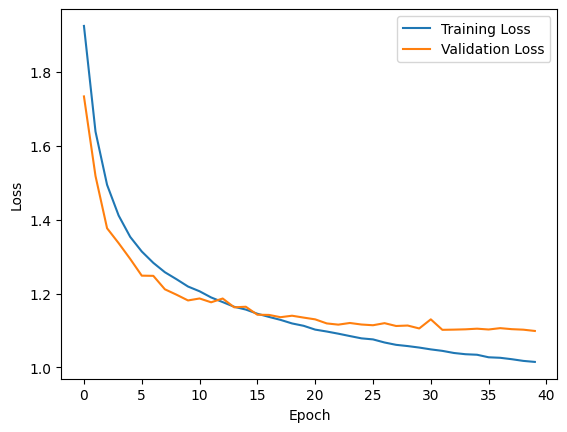

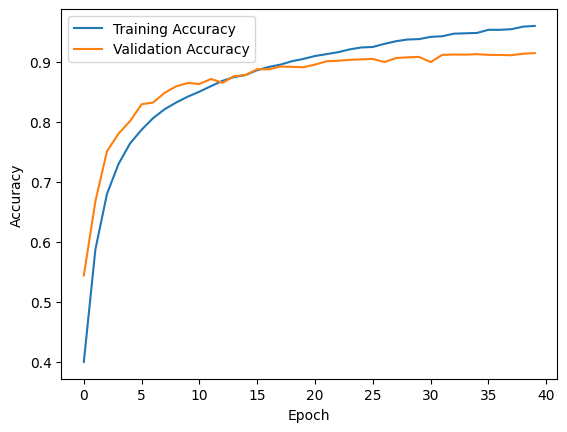

In [6]:
import time
import matplotlib.pyplot as plt

# Training parameters
num_epochs = 40
print_every = 5

# Store the loss and accuracy history
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

start_time = time.time()

# Loop through each epoch
for epoch in range(num_epochs):
    # Train the model for one epoch and calculate training loss and accuracy
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    # Validate the model and calculate validation loss and accuracy
    val_loss, val_acc = validate_epoch(model, testloader, criterion, device)

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Print the losses and accuracies for the current epoch if it's a multiple of 'print_every'
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

end_time = time.time()

print(f'Training finished in {(end_time - start_time):.2f} seconds.')

# Plot loss curves
plt.figure()
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Validation Set Visualization** - In this section, we visualize a random subset of the validation set with predicted and actual labels. The purpose of this visualization is to give an intuitive understanding of the performance of our model on the validation set. The images are displayed along with their corresponding predicted and actual labels.

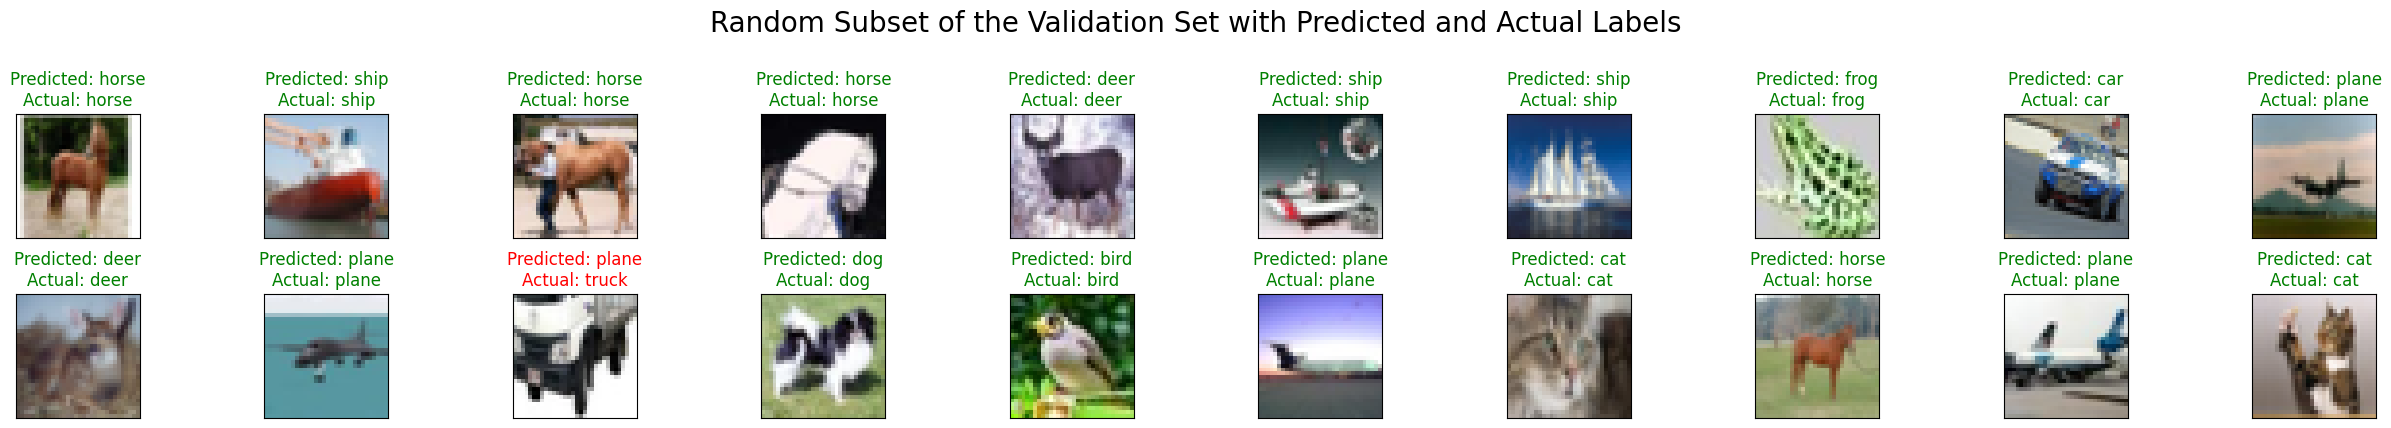

In [7]:
# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predictions and actual labels
preds = []
targets = []

# Loop through the validation data and collect predictions and actual labels
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

# Convert the list of predictions and actual labels to numpy arrays
preds = np.array(preds)
targets = np.array(targets)

# Visualize a random subset of the validation set with predicted and actual labels
fig = plt.figure(figsize=(25, 8))
fig.suptitle("Random Subset of the Validation Set with Predicted and Actual Labels", fontsize=20)

for i in range(20):
    index = np.random.randint(0, len(preds))
    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(testset.data[index])
    ax.set_title(f"Predicted: {classes[preds[index]]}\nActual: {classes[targets[index]]}", color=("green" if preds[index]==targets[index] else "red"), fontsize=12)
    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()

**Conclusion** - In conclusion, this Jupyter Notebook demonstrates the successful implementation of a custom deep learning model (according to given requirements) for image classification on the CIFAR-10 dataset. The model's architecture consists of adaptive convolutions, residual connections, and a custom loss function that combines Cross-Entropy Loss with Kullback-Leibler Divergence Loss. With a training accuracy of 95.94% and a validation accuracy of 91.42%, the model demonstrates strong performance in classifying images in the dataset.

In the validation set visualization section, we display 20 images alongside their predicted and actual labels. Out of these 20 images, the model correctly classifies 19, showing that the custom architecture and loss function have indeed learned to generalize well on unseen data. The single misclassification serves as a reminder that even well-performing models can occasionally make mistakes, and it highlights the importance of continuous evaluation and improvement.

Overall, this notebook provides valuable insights into the effectiveness of the custom model and loss function on the CIFAR-10 dataset and serves as a strong foundation for further exploration and optimization of deep learning models for image classification tasks.

**REFERENCES** <br>

General:
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
3. https://www.pluralsight.com/guides/image-classification-with-pytorch

Data Augmentation:
1. https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9
2. https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch

Convolutions:
1. https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215

Residual Learning:
1. https://towardsdatascience.com/a-deeper-dive-into-residual-learning-d92e0aaa8b32

Creating Custom Loss Functions:
1. https://towardsdatascience.com/implementing-custom-loss-functions-in-pytorch-50739f9e0ee1
2. https://towardsdatascience.com/label-smoothing-as-another-regularization-trick-7b34c50dc0b9

Gradient Accumulation:
1. https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html#3.-How-to-make-it-work